# Data Cleaning and EDA

This notebook serves the purpose of ingesting, preparing and analyzing the main dataset used for the thesis, the HMDA mortgage dataset. The dataset is a collection of mortgage applications in the United States, and it contains information about the applicants, the loans, and the outcomes of the applications. The dataset is publicly available and can be found [here](https://ffiec.cfpb.gov/data-browser/data/2022?category=states). 

## Data Ingestion

The data in question (Please refer to the corresponding chapter within the thesis for a detailed description of the applied filters and their rationale) is available for download in a .csv format and can therefore be ingested as a dataframe using the inbuilt read_csv function of the pandas library.

In [53]:
import numpy as np
import pandas as pd

In [54]:
HMDA_raw = pd.read_csv("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/raw/HMDA/CA_2022_SingleFamily_Built.csv")

C:\Users\Hauke\AppData\Local\Temp\ipykernel_48248\1082769657.py:1: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,44) have mixed types. Specify dtype option on import or set low_memory=False.
  HMDA_raw = pd.read_csv("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/raw/HMDA/CA_2022_SingleFamily_Built.csv")


## Exploratory Data Analysis (EDA) - Raw Data

In order to prepare the data for processing, its raw form is analyzed in order to identify potential issues and to gain a better understanding of the data. In order to do so, basic EDA steps will be conducted at this stage, before more refined analyses will be conducted after the data has been cleaned and prepared for processing.

In [55]:
HMDA_raw.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,5493000YNV8IX4VD3X12,40140,CA,6065.0,6.065044e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,3895,72.04,87400,51,637,1091,46
1,2022,5493000YNV8IX4VD3X12,40140,CA,6065.0,6.065041e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,4599,75.80,87400,92,1231,1560,36
2,2022,5493000YNV8IX4VD3X12,40140,CA,6065.0,6.065042e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,3835,83.94,87400,78,154,416,10
3,2022,5493000YNV8IX4VD3X12,33700,CA,6099.0,6.099000e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,8312,42.61,79300,129,1584,2342,20
4,2022,5493000YNV8IX4VD3X12,37100,CA,6111.0,6.111001e+09,NC,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,2107,26.39,115400,128,512,942,50


In [56]:
HMDA_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503537 entries, 0 to 1503536
Data columns (total 99 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   activity_year                             1503537 non-null  int64  
 1   lei                                       1503537 non-null  object 
 2   derived_msa-md                            1503537 non-null  int64  
 3   state_code                                1503537 non-null  object 
 4   county_code                               1493002 non-null  float64
 5   census_tract                              1492061 non-null  float64
 6   conforming_loan_limit                     1503537 non-null  object 
 7   derived_loan_product_type                 1503537 non-null  object 
 8   derived_dwelling_category                 1503537 non-null  object 
 9   derived_ethnicity                         1503537 non-null  object 
 10  derive

In [57]:
HMDA_raw.describe()

,activity_year,derived_msa-md,county_code,census_tract,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
count,1503537.0,1.503537e+06,1.493002e+06,1.492061e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,...,40759.000000,7054.000000,793.000000,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06
mean,2022.0,3.620769e+04,6.057078e+03,6.057253e+09,2.501587e+00,4.981873e+00,1.981012e+00,1.201846e+00,1.418716e+01,1.207833e+00,...,5.002233,6.271761,7.315259,5.020362e+03,5.905775e+01,1.031129e+05,1.166305e+02,1.053468e+03,1.480468e+03,3.993513e+01
std,0.0,1.390486e+04,2.661617e+01,2.714773e+07,1.775274e+00,1.646557e+01,1.364821e-01,5.181575e-01,1.481168e+01,4.057565e-01,...,2.670639,2.375737,2.081419,1.939129e+03,2.383132e+01,2.697459e+04,4.712574e+01,5.127602e+02,6.070215e+02,1.832085e+01
min,2022.0,0.000000e+00,6.001000e+03,6.001400e+09,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022.0,3.108400e+04,6.037000e+03,6.037408e+09,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.000000,4.000000,6.000000,3.740000e+03,3.954000e+01,8.740000e+04,8.400000e+01,6.880000e+02,1.071000e+03,2.700000e+01
50%,2022.0,4.014000e+04,6.065000e+03,6.065042e+09,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,...,4.000000,6.000000,9.000000,4.864000e+03,5.903000e+01,9.110000e+04,1.110000e+02,1.004000e+03,1.429000e+03,4.200000e+01
75%,2022.0,4.174000e+04,6.073000e+03,6.073017e+09,4.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,3.200000e+01,1.000000e+00,...,7.000000,9.000000,9.000000,6.079000e+03,8.020000e+01,1.154000e+05,1.440000e+02,1.362000e+03,1.854000e+03,5.400000e+01
max,2022.0,9.999900e+04,6.115000e+03,1.306703e+10,8.000000e+00,7.200000e+01,2.000000e+00,4.000000e+00,3.200000e+01,2.000000e+00,...,9.000000,9.000000,9.000000,3.789200e+04,1.000000e+02,1.683000e+05,3.270000e+02,3.467000e+03,7.708000e+03,8.000000e+01


In [58]:
HMDA_raw["loan_amount"].sum()

755869735000.0

## Data Preparation

Due to the sheer size of the dataset, several preprocessing steps need to be taken before the actual EDA can be conducted. These steps include the removal of irrelevant columns, the handling of missing values, and the encoding of categorical variables.

### Reducing amount of features

The raw dataset contains 99 features (CHECK!!!). Many of these are highly relevant to this analysis, but in order to find a compromise between model performance and computational efficiency, only a subset of features will be used for further analysis. In the following step, all features which can be reasoned to not benefit the analysis are removed from the dataset. Details on the reasoning behind the removal of each feature can be found below.

In [59]:
HMDA_clean = HMDA_raw.copy()

In the first step, several "administrative" features which are not relevant for the analysis are removed. These are:
- **activity_year**: Does not provide value as the year is already pre-filtered
- **lei**: Does not matter as all financial institutions are used
- **derived_msa-md**: Does not matter as county code is the geographical variable used in the analysis
- **state_code**: Does not matter as the state is already pre-filtered
- **census_tract**: Not relevant for the analysis
- **derived_dwelling_category**: Does not matter as the building category is already pre-filtered

In [60]:
HMDA_clean = HMDA_clean.drop(columns=["activity_year", "lei", "derived_msa-md", "state_code", "census_tract", "derived_dwelling_category"])

While information on both the applicant and the co-applicant is available, the focus of the following analyses should be the main applicant. Therefore, all features related to the co-applicant are removed.

In [61]:
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='co-applicant')))]

Reasons for Denial are dropped, as only the classification of the loan is of interest

In [62]:
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='denial_reason')))]

The dataset contains geographical information based on census tracts. As, however, the analysis of geographical features will be based on county level, the census tract is dropped.

In [63]:
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='tract_')))]
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='ffiec_msa_md_median_family_income')))]

The dataset contains both actual information on specific protected attributes (e.g. "applicant_ethnicity-1" to "applicant_erthniciy-5") and derived information that aggregate the former into one overarching category (e.g. "derived_ethnicity"). As this analysis focuses on fairness concerns, where such protected attributes play an important role, the derived information is dropped in favor of the actual information in order to achieve a higher granularity of this important type of data. However, as only few applicants have made use of all the fields (for example, only 0.07% of applicants have reported more than two ethnicities), the amount of features is reduced by only including the top two selections for each protected attribute. This is done in order to avoid a high amount of missing values in the dataset as well as to strike a balance between the amount of features (and therefore model performance) and the granularity of the data.

In [64]:
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='derived')))]
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='-3')))]
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='-4')))]
HMDA_clean = HMDA_clean[HMDA_clean.columns.drop(list(HMDA_clean.filter(regex='-5')))]

### EDA after feature reduction

This is the first analysis of the remaining features. All features that could be dropped for logical reasons have been removed, and the remaining features are analyzed in order to identify potential issues and to gain a better understanding of the data. This is done in order to identify potential issues that need to be addressed in the next step, the data cleaning.

In [82]:
HMDA_clean.shape

(1503537, 52)

The dataset still has 52 (!!!!!!) features remaining. The amount of items has not yet been reduced. The following EDA steps will mainly focus on data completeness and data types, as well as the distribution of the remaining features.

In [65]:
HMDA_clean.head()

,county_code,conforming_loan_limit,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,...,applicant_race-2,applicant_race_observed,applicant_sex,applicant_sex_observed,applicant_age,applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2
0,6065.0,C,6,0,2,1,5,1,2,2,...,NaN,3,4,3,8888,NaN,3,3,6,NaN
1,6065.0,C,6,0,2,2,5,1,2,2,...,NaN,3,4,3,8888,NaN,3,3,6,NaN
2,6065.0,C,6,0,2,2,1,1,2,2,...,NaN,3,4,3,8888,NaN,3,3,6,NaN
3,6099.0,C,1,1,2,1,1,1,2,2,...,NaN,2,1,2,45-54,No,1,1,1,NaN
4,6111.0,NC,3,0,2,1,31,1,2,2,...,NaN,2,1,2,55-64,No,1,1,6,NaN


In [66]:
HMDA_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503537 entries, 0 to 1503536
Data columns (total 52 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   county_code                               1493002 non-null  float64
 1   conforming_loan_limit                     1503537 non-null  object 
 2   action_taken                              1503537 non-null  int64  
 3   purchaser_type                            1503537 non-null  int64  
 4   preapproval                               1503537 non-null  int64  
 5   loan_type                                 1503537 non-null  int64  
 6   loan_purpose                              1503537 non-null  int64  
 7   lien_status                               1503537 non-null  int64  
 8   reverse_mortgage                          1503537 non-null  int64  
 9   open-end_line_of_credit                   1503537 non-null  int64  
 10  busine

In [67]:
HMDA_clean.describe()

,county_code,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,...,applicant_ethnicity_observed,applicant_race-1,applicant_race-2,applicant_race_observed,applicant_sex,applicant_sex_observed,submission_of_application,initially_payable_to_institution,aus-1,aus-2
count,1.493002e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,...,1.503537e+06,1.503145e+06,174743.000000,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,1.503537e+06,127657.000000
mean,6.057078e+03,2.501587e+00,4.981873e+00,1.981012e+00,1.201846e+00,1.418716e+01,1.207833e+00,7.539741e+00,7.367562e+00,7.743682e+00,...,2.111181e+00,5.329366e+00,21.589031,2.109359e+00,1.725825e+00,2.110209e+00,7.090578e+00,6.987861e+00,1.031965e+01,2.084359
std,2.661617e+01,1.775274e+00,1.646557e+01,1.364821e-01,5.181575e-01,1.481168e+01,4.057565e-01,7.831285e+01,7.832594e+01,7.998826e+01,...,3.544959e-01,3.274854e+00,6.579014,3.536678e-01,9.521703e-01,3.547938e-01,7.917898e+01,7.918662e+01,8.464235e+01,1.415688
min,6.001000e+03,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
25%,6.037000e+03,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,5.000000e+00,21.000000,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
50%,6.065000e+03,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,5.000000e+00,22.000000,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,2.000000
75%,6.073000e+03,4.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,3.200000e+01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,6.000000e+00,24.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,6.000000e+00,2.000000
max,6.115000e+03,8.000000e+00,7.200000e+01,2.000000e+00,4.000000e+00,3.200000e+01,2.000000e+00,1.111000e+03,1.111000e+03,1.111000e+03,...,3.000000e+00,4.400000e+01,44.000000,3.000000e+00,6.000000e+00,3.000000e+00,1.111000e+03,1.111000e+03,1.111000e+03,7.000000


Several columns are cast as objects, but should be cast as numerical values. The following steps aim to gain insight into which features are of object type and why.

In [83]:
HMDA_clean.dtypes[HMDA_clean.dtypes == "object"]

object_columns = list(HMDA_clean.select_dtypes(include=['object']).columns)

In [85]:
HMDA_clean[object_columns].head(15)

,conforming_loan_limit,loan_to_value_ratio,interest_rate,rate_spread,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,property_value,multifamily_affordable_units,debt_to_income_ratio,applicant_age,applicant_age_above_62
0,C,NaN,6.99,NaN,NaN,NaN,NaN,NaN,NaN,480,NaN,NaN,275000.0,NaN,NaN,8888,NaN
1,C,NaN,4.375,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,315000.0,NaN,NaN,8888,NaN
2,C,NaN,3.5,NaN,10574.0,NaN,995.0,NaN,2170.63,360,NaN,NaN,395000.0,NaN,NaN,8888,NaN
3,C,43.182,5.25,0.185,4342.0,NaN,1232.5,237.5,8.0,360,NaN,NaN,445000.0,NaN,20%-<30%,45-54,No
4,NC,53.731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,2605000.0,NaN,<20%,55-64,No
5,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,NaN,NaN,NaN,25-34,No
6,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,NaN,NaN,NaN,45-54,No
7,C,75.0,7.5,0.605,6005.0,NaN,1595.0,600.0,211.5,360,NaN,NaN,645000.0,NaN,46,45-54,No
8,NC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,NaN,NaN,NaN,55-64,Yes
9,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,NaN,NaN,NaN,NaN,NaN,55-64,No


The object type columns seem to partially be wrongly encoded numerical values and in part categorical variables. This will be important in the upcoming data cleaning steps.

The next step is to identify the missing values and to assess whether they are MCAR, MAR, or MNAR, which is important to know in order to decide on how to proceed with the missing values.

In [70]:
HMDA_clean.isnull().sum().sort_values(ascending=False)

multifamily_affordable_units                1496109
total_points_and_fees                       1484569
prepayment_penalty_term                     1381569
aus-2                                       1375880
applicant_ethnicity-2                       1346991
applicant_race-2                            1328794
lender_credits                              1235230
discount_points                             1127409
intro_rate_period                           1116434
total_loan_costs                             808930
origination_charges                          793497
rate_spread                                  772188
interest_rate                                543270
debt_to_income_ratio                         522567
loan_to_value_ratio                          500712
property_value                               332504
income                                       162449
applicant_age_above_62                       139119
loan_term                                     37032
county_code 

There are several columns with missing values, some of them being majorly incomplete. The next step is to assess the missing values in more detail and to decide on how to proceed with them. First, the values within the columns are checked in order to understand what the missing values represent.

In [86]:
for item in HMDA_clean.isnull().sum().sort_values(ascending=False)[:10].index:
    print(item, HMDA_clean[item].unique())

multifamily_affordable_units [nan 'Exempt']
total_points_and_fees [nan 'Exempt' '0.0' ... '15274.76' '10049.0' '14355.94']
prepayment_penalty_term [nan 60.0 36.0 24.0 12.0 'Exempt' 18.0 300.0 '36' '12' '24' '60' '5' 0.0
 48.0 '6' '48' '3' '2' 2]
aus-2 [nan  2.  1.  3.  5.  7.  4.]
applicant_ethnicity-2 [nan 11. 12. 14.  2. 13.  1.]
applicant_race-2 [nan 21.  5. 24. 22. 27. 23. 25.  3. 26. 42.  4.  2. 44. 43. 41.  1.]
lender_credits [nan 2170.63 8.0 ... '3705.45' '4166.5' '1020.06']
discount_points [nan 237.5 600.0 ... '4132.07' '5830.63' '7027.65']
intro_rate_period [nan 120.0 84.0 60.0 36.0 62.0 180.0 63.0 61.0 6.0 360.0 '60' '84' '360'
 '120' 'Exempt' '1' '180' 12.0 1.0 48.0 64.0 4.0 '12' '6' 3.0 '299' '2'
 '61' '66' '30' '36' 2.0 13.0 5.0 '3' '9' '24' '3012022' '111' '114' '62'
 '90' '83' '64' '11' '10' '7' 96.0 '4' '5' '96' '13' '72' 9.0 98.0 14.0
 16.0 15.0 11.0 17.0 22.0 58.0 '35' '25' '63' '85' '48' '8' '18' '91' '21'
 '68' '37' '108' '92' '89' '106' '87' '103' '97' '14' '17' '1

Following up, the missingno package (https://github.com/ResidentMario/missingno?tab=readme-ov-file) is utilized to visualize the missing values in the dataset in order to find patterns upon optical inspection.

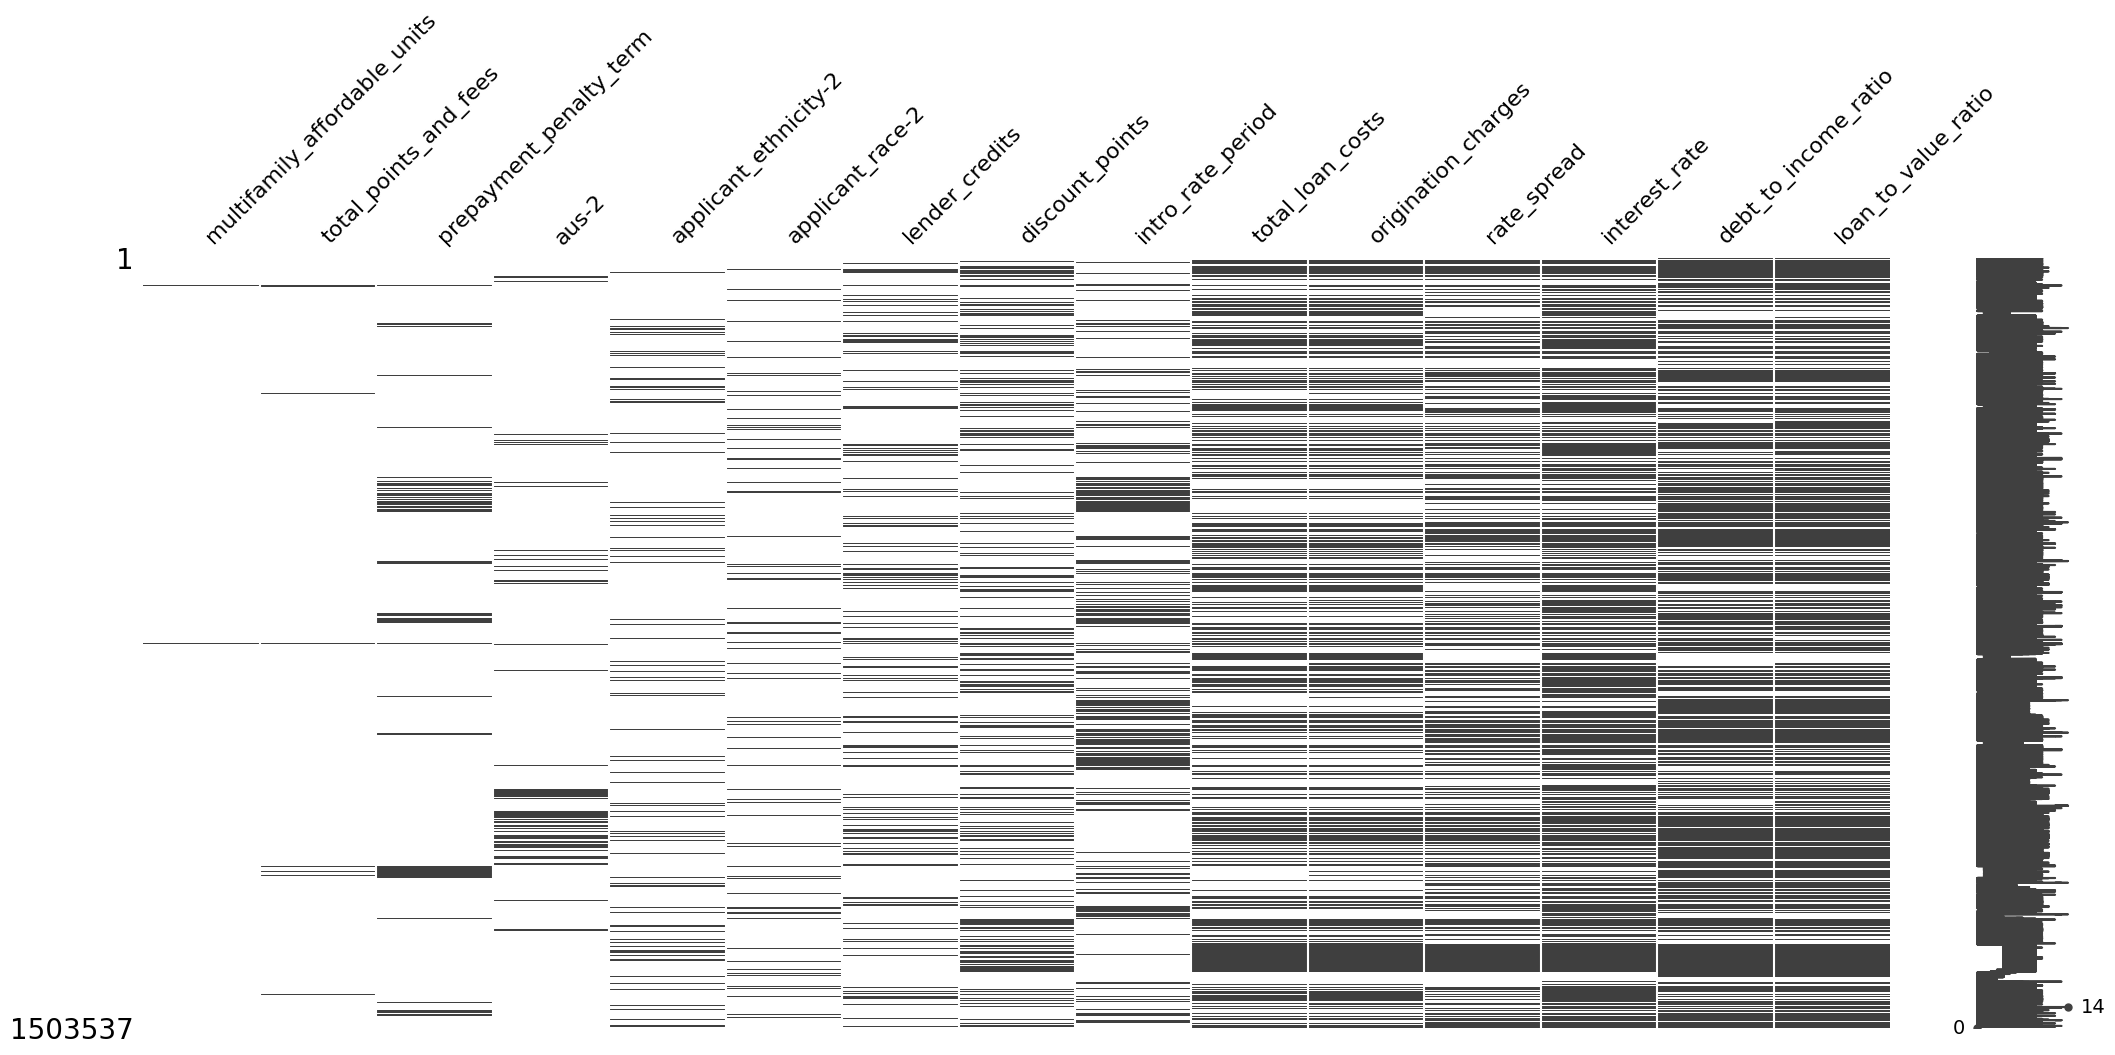

In [87]:
import missingno as msno
msno.matrix(HMDA_clean[HMDA_clean.isnull().sum().sort_values(ascending=False).head(15).index]);

XXX Problem: Might change with new data XXX

There are several columns containing a high amount of missing values (see above). The procedure for handling these missing values is as follows:
- **multifamily_affordable_units**: This column seems to be erroneous, as it contains only one unique value ("Exempt"), whereas it is supposed to contain percentages according to the documentation. It is therefore dropped. 
- **total_points_and_fees**, **prepayment_penalty_term**, **lender_credits**,  **discount_points**, and **intro_rate_period**: These might have been interesting to include in the analysis. However, the sheer amount of missingness (which seems to be MCAR from visual inspection) makes them unsuitable for the analysis. They are therefore dropped.
- **aus-2**: This column refers to a second underwriting system for the loan. As the vast majority of loans only have one underwriting system and, opposed to the second variables for the protected attributes, information on aus-2 does not add value to the analysis, this column is dropped.
- **applicant-ethnicity-2** and **applicant_race-2**: As discussed above, these are part of the highly important protected attributes. Even though the amount of missing values is high and imputation is not suitable here for logical reasons, these columns will be kept including their missing values in order to not lose the granularity of the data.

To-Do
- Drop NA where required (reasoning!) - Check Imputation for other features
- Specify procedure for outliers
- Binary loan grant variable for classification (and drop of action taken)
- Check standardization of features
- Formatting (check dtypes!) - check if all objects are categorizable and change to 0/1
- Formally categorize features
- Maybe do first round of cleaning, then EDA and then further cleaning
- Interaction Terms for protected attributes